# Add watermarks to images

## Problem

You need to add watermarks to hundreds of different images to protect copyright, add branding, or mark drafts.

## Solution

**What's in this recipe:**

- Create simple text watermarks
- Test transformations before applying
- Apply to multiple images automatically

You add watermarks to images using a custom UDF that wraps Pillow's `ImageDraw` (relies on PIL/Pillow). This gives you full control over watermark placement, font, transparency, and color.

You can iterate on transformations before adding them to your table. Use `.select()` with `.collect()` to preview results on sample images—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()`. Once you're satisfied, use `.add_computed_column()` to apply watermarks to all images in your table.

For more on this workflow, see [Get fast feedback on transformations](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow).

### Setup

In [1]:
%pip install -qU pixeltable

In [2]:
import pixeltable as pxt
from PIL import Image, ImageDraw, ImageFont

### Load images

In [3]:
# Create a fresh directory (drop existing if present)
pxt.drop_dir('image_demo', force=True)
pxt.create_dir('image_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'image_demo'.


In [4]:
t = pxt.create_table('image_demo.watermarks', {'image': pxt.Image})

Created table 'watermarks'.


In [5]:
t.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000049.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000090.jpg'},
])

Inserting rows into `watermarks`: 0 rows [00:00, ? rows/s]

Inserting rows into `watermarks`: 3 rows [00:00, 532.86 rows/s]


Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

### Iterate: add watermarks to a few images first

In [6]:
@pxt.udf
def add_watermark(img: Image.Image, text: str) -> Image.Image:
    """Add a watermark to bottom-right corner."""
    img = img.copy().convert('RGBA')
    overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # Draw white text in bottom-right corner
    font = ImageFont.load_default(size=40)
    position = (img.width - 150, img.height - 60)
    draw.text(position, text, font=font, fill=(255, 255, 255, 200))

    result = Image.alpha_composite(img, overlay)
    return result.convert('RGB')

image,add_watermark
,

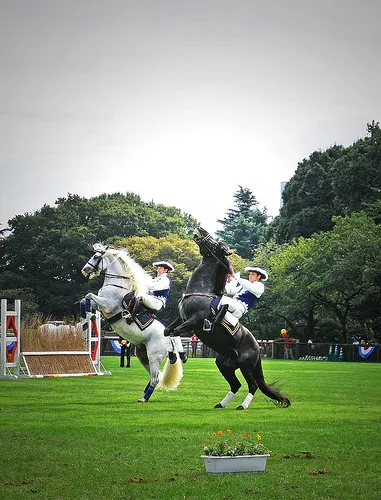
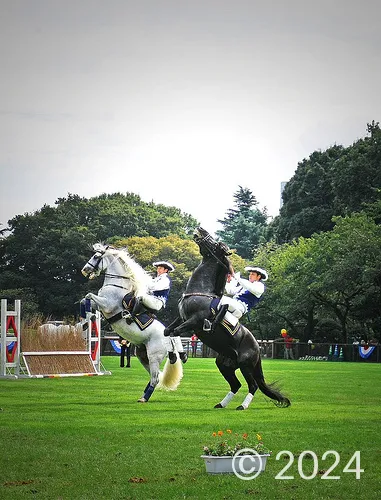

In [7]:
# Test on first image
t.select(t.image, add_watermark(t.image, '© 2024')).head(1)

### Add: add watermarks to all images in your table

In [8]:
# Add watermark to all images
t.add_computed_column(watermarked=add_watermark(t.image, '© 2024'))

Added 3 column values with 0 errors.


3 rows updated, 3 values computed.

image,watermarked
,
,
,

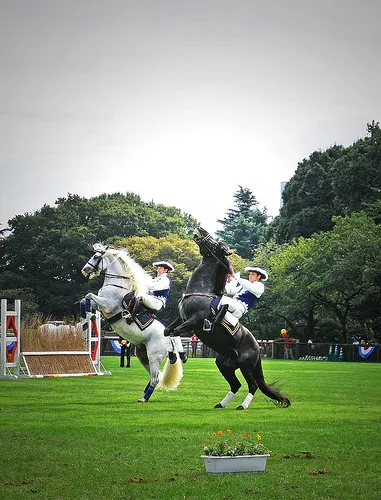
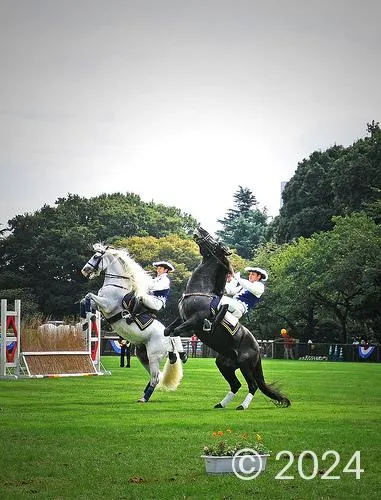
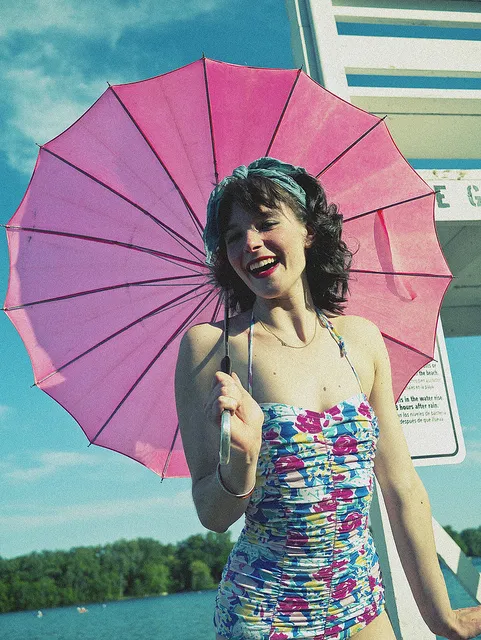
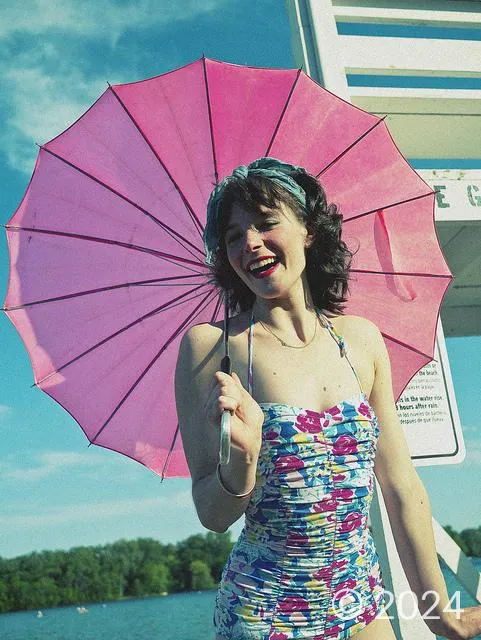
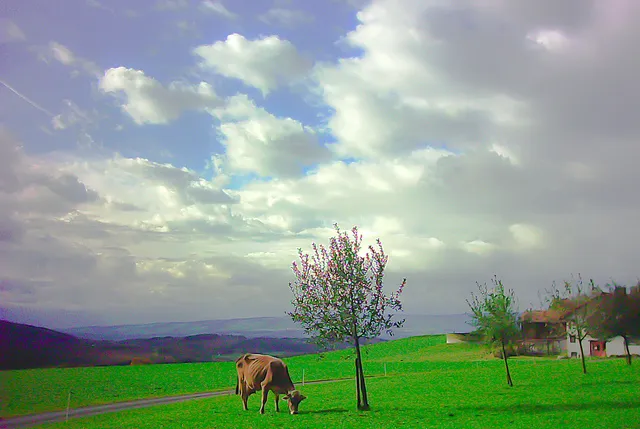
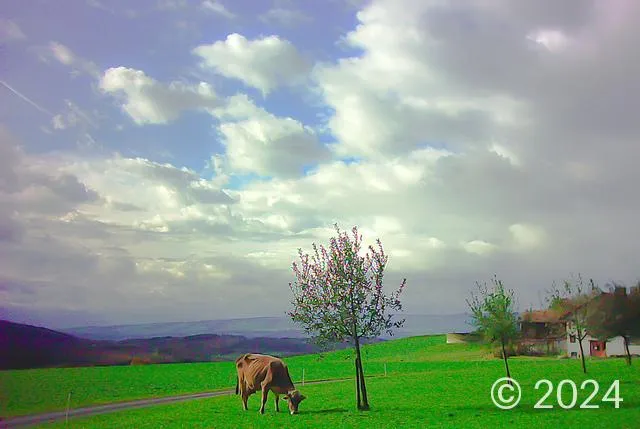

In [9]:
# View all results
t.collect()

## Explanation

**How the watermark technique works:**

The UDF creates a transparent overlay on top of each image. The overlay is created with the same dimensions as the image (`Image.new('RGBA', img.size, ...)`), so watermarks adapt automatically whether you're processing small thumbnails or large photos. The function draws white text with semi-transparent fill (alpha=200, where 255 is fully opaque), composites the overlay onto the original image using `Image.alpha_composite()`, and converts back to RGB since most image formats don't support transparency.

**To customize the UDF:**
- Position: Change the `(x, y)` coordinates in the `position` variable
- Color: Modify the `(R, G, B, Alpha)` fill value (0-255 for each)
- Size: Adjust the font size parameter in `ImageFont.load_default(size=40)`
- Font: Use `ImageFont.truetype('path/to/font.ttf', size)` for custom fonts

**The Pixeltable workflow:**

In traditional databases, `.select()` just picks which columns to view. In Pixeltable, `.select()` also lets you compute new transformations on the fly—define new columns without storing them. This makes `.select()` perfect for testing transformations before you commit them.

When you use `.select()`, you're creating a query that doesn't execute until you call `.collect()`. You must use `.collect()` to execute the query and return results—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()` to test on a subset before processing your full dataset. Once satisfied, use `.add_computed_column()` with the same expression to persist results permanently.

For more on this workflow, see [Get fast feedback on transformations](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow).

## See also

- [Test transformations with fast feedback loops](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow)
- [Transform images with PIL operations](https://docs.pixeltable.com/howto/cookbooks/images/img-pil-transforms)
- *Pillow techniques from [Real Python: Image Processing With the Python Pillow Library](https://realpython.com/image-processing-with-the-python-pillow-library/)*